<a href="https://colab.research.google.com/github/nishant3101/Computer-Vision-Assignments-and-Homeworks/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CV Assignment -3 
Nishant Kumar / 2017171

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import math
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io
import numpy as np
import argparse
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import quad
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import math
from sklearn.model_selection import train_test_split
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.4.1


In [ ]:
import keras
from keras.datasets import mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = mnist.load_data()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
y_train_1=y_train.reshape(len(y_train),1)
y_train_onehot=one_hot_encoder.fit_transform(y_train_1)
y_test_1=y_test.reshape(len(y_test),1)
y_test_onehot=one_hot_encoder.fit_transform(y_test_1)


In [ ]:
y_train_onehot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [ ]:
def resized(olddata):
  new_data=[]
  for i in range(len(olddata)):
    cur_img=olddata[i]
    new_img=cv2.resize(x_train[0], dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    new_data.append(new_img)
  new_data=np.asarray(new_data)
  return new_data

In [ ]:
#x_train=resized(x_train)
#x_test=resized(x_test)

## 1a

In [ ]:
def otsu_algorithm(grayimage):
  total_pixels=grayimage.size
  histogram=cv2.calcHist([grayimage],[0],None,[256],[0,256])
  histogram=histogram.astype(int)
  intra_class_array=[]
  #so histogram has 255 values 
  for i in range(1,len(histogram)):
    part1,part2=np.split(histogram,[i])
    w1=(np.sum(part1))/total_pixels
    w2=(np.sum(part2))/total_pixels
    #weights of both classes done, now calculate variance of both the classes
    mean1=np.sum([x*y for x,y in enumerate(part1)])/(np.sum(part1)+0.00001)  #here x is the pixel value and y is the number of pixels for that value
    mean2=np.sum([x2*y2 for x2,y2 in enumerate(part2)])/(np.sum(part2)+0.0001)
    variance1=np.sum([(x-mean1)**2*y for x,y in enumerate(part1)])
    variance2=np.sum([(x-mean2)**2*y for x,y in enumerate(part2)])
    variance1=np.nan_to_num(variance1)
    variance2=np.nan_to_num(variance2)
    mean1=np.nan_to_num(mean1)
    mean2=np.nan_to_num(mean2)
    intra_class=(variance1)+(variance2)
    intra_class_array.append(intra_class)

  min_value=np.argmin(intra_class_array)
  #print("Final threshold is:")
  #print(min_value)
  #print("TSS is ")
  #print(intra_class_array[min_value])
  return min_value

In [ ]:
def thresholdimage(old_image,new_image,threshold):
  rows=old_image.shape[0]
  cols=new_image.shape[1]
  for i in range(rows):
    for j in range(cols):
      if (old_image[i][j]<threshold):
        new_image[i][j]=0
      else:
        new_image[i][j]=255
        
  return new_image

In [ ]:
def onea(dataset):
  new_dataset=[]
  for i in range(len(dataset)):
    cur_img=dataset[i]
    new_img=np.zeros((cur_img.shape[0],cur_img.shape[1]))
    otsu_thr,new_img = cv2.threshold(cur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #threshold=otsu_algorithm(cur_img)
    #new_img=thresholdimage(cur_img,new_img,threshold)
    new_dataset.append(new_img)
  new_dataset=np.asarray(new_dataset)
  return new_dataset

In [ ]:
new_training=onea(x_train)
new_testing=onea(x_test)

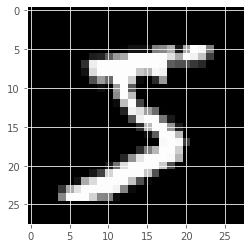

In [ ]:
#plt.imshow(new_training[0],cmap='gray')
plt.imshow(x_train[0],cmap='gray')

## 1b

In [ ]:
def oneb(dataset,orig_labels):
  new_dataset=[]
  for i in range(len(dataset)):
    cur_img=dataset[i]
    cur_label=orig_labels[i]
    contours,hierarchy = cv2.findContours(cur_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    (x,y),radius = cv2.minEnclosingCircle(cnt)
    center = (int(x),int(y))
    radius = int(radius)
    cur_label=cur_label.astype(int)
    cur_label=cur_label.tolist()
    cur_label.extend((center[0],center[1],radius))
    new_dataset.append([center[0],center[1],radius])
    #img = cv2.circle(x_train[0],center,radius,(255,255,255),2)
  
  return np.asarray(new_dataset)




In [ ]:
oneb_train=oneb(new_training,y_train_onehot)
oneb_test=oneb(new_testing,y_test_onehot)

In [ ]:
oneb_train[0]

array([13, 14, 13])

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [ ]:
new_training_copy=new_training.copy()
new_training_copy = new_training_copy.reshape(new_training_copy.shape[0], 28, 28, 1)
new_testing_copy=new_testing.copy()
new_testing_copy = new_testing_copy.reshape(new_testing_copy.shape[0], 28, 28, 1)

In [ ]:
x_train=x_train/255
x_test=x_test/255

In [ ]:
new_training_copy=new_training_copy/255
new_testing_copy=new_testing_copy/255

In [ ]:
np.unique(new_testing_copy[0])

array([0., 1.])

In [ ]:
def draw_circle(image,parameters):
  cx=int(parameters[0])
  cy=int(parameters[1])
  radius=int(parameters[2])
  image_copy=image.copy()
  image_copy = cv2.circle(image_copy, (cx,cy), radius, (255,0,0), 1)
  plt.imshow(image_copy,cmap='gray')
  print('Center Coordinates are:',parameters[0],parameters[1])
  print('Radius is:',parameters[2])

In [ ]:
post_pred[1][1]

array([15.87403488, 12.90091324, 11.19683456])

Center Coordinates are: 15.874034881591797 12.90091323852539
Radius is: 11.196834564208984


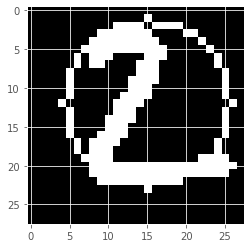

In [ ]:
draw_circle(new_testing[1],post_pred[1][1])

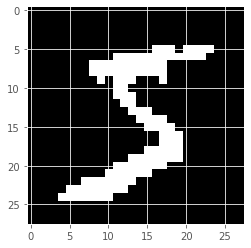

In [ ]:
plt.imshow(new_training[0],cmap='gray')

In [ ]:
print(1,2)

1 2


## 2

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.4.1


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=new_training_copy.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))
#-------------------------
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
results = model.fit(x_train, new_training_copy, batch_size=128, epochs=40, callbacks=callbacks,
                    #validation_data=(x_test, new_testing_copy),
                    shuffle=True,
                    validation_split=0.2
                    )

Epoch 1/40
375/375 [==============================] - 6s 14ms/step - loss: 0.2017 - binary_accuracy: 0.9197 - val_loss: 0.0409 - val_binary_accuracy: 0.9829

Epoch 00001: val_loss improved from inf to 0.04095, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3.h5
Epoch 2/40
375/375 [==============================] - 5s 13ms/step - loss: 0.0374 - binary_accuracy: 0.9843 - val_loss: 0.0311 - val_binary_accuracy: 0.9869

Epoch 00002: val_loss improved from 0.04095 to 0.03109, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3.h5
Epoch 3/40
375/375 [==============================] - 5s 13ms/step - loss: 0.0302 - binary_accuracy: 0.9873 - val_loss: 0.0273 - val_binary_accuracy: 0.9885

Epoch 00003: val_loss improved from 0.03109 to 0.02727, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3.h5
Epoch 4/40
375/375 [==============================] - 5s 13ms/step - loss: 0.0266 - bi

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 32)         

In [ ]:
model.save('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3_copy.h5')

In [ ]:
#model = load_model('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/model3.h5')
model = load_model('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q2model_val_3_copy.h5')

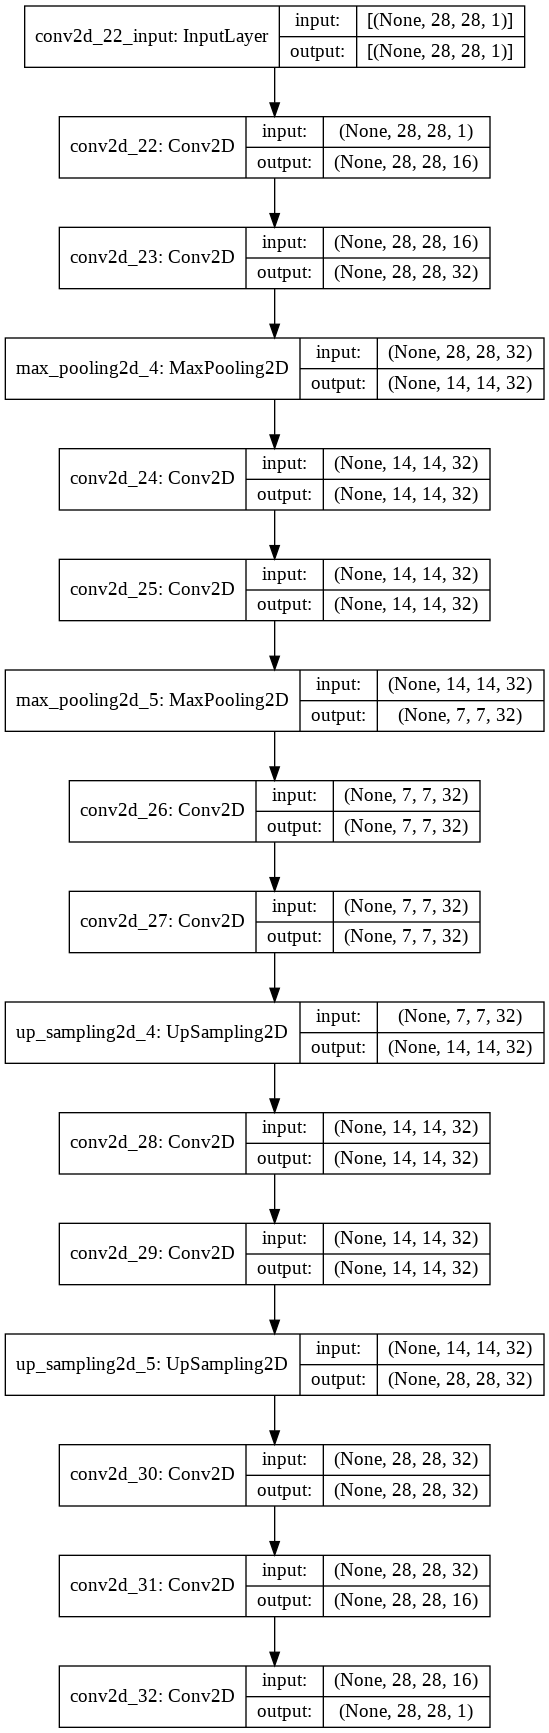

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/model_plot_q2.png', show_shapes=True, show_layer_names=True)

In [ ]:
op=model.predict(x_test)

In [ ]:
op2=op[0].copy()
op2=op2.reshape(28,28)
lab=new_testing_copy[0].copy()
lab=lab.reshape(28,28)

In [ ]:
np.unique(lab)

array([0., 1.])

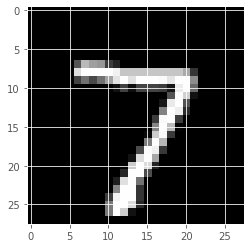

In [ ]:
plt.imshow(x_test_orig[0],cmap='gray')

In [ ]:
#haha=np.asarray(haha)
op2ar=np.asarray(op2)
labar=np.asarray(lab)

In [ ]:
for i in range(op2ar.shape[0]):
  for j in range(op2ar.shape[1]):
    if(op2ar[i][j]>=0.5):
      op2ar[i][j]=255
    else:
      op2ar[i][j]=0


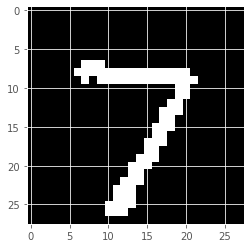

In [ ]:
plt.imshow(op2ar,cmap='gray')

In [ ]:
for i in range(labar.shape[0]):
  for j in range(labar.shape[1]):
    if (labar[i][j]==1):
      labar[i][j]=255
    else:
      labar[i][j]=0

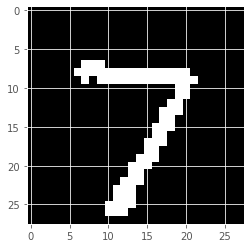

In [ ]:
plt.imshow(labar,cmap='gray')

In [ ]:
np.unique(new_testing_copy[0])

array([0., 1.])

In [ ]:
def calcjaccard(orig,predicted):
  avg_jac=0.0
  for i in range(len(orig)):
    cur_orig=orig[i].copy()
    cur_pred=predicted[i].copy()
    cur_orig=cur_orig.reshape(28,28)
    cur_pred=cur_pred.reshape(28,28)
    cur_orig=np.asarray(cur_orig)
    cur_pred=np.asarray(cur_pred)
    for i in range(cur_pred.shape[0]):
      for j in range(cur_pred.shape[1]):
        if cur_pred[i][j]>=0.5:
          cur_pred[i][j]=255
        else:
          cur_pred[i][j]=0

    for i in range(cur_orig.shape[0]):
      for j in range(cur_orig.shape[1]):
        if cur_orig[i][j]==1:
          cur_orig[i][j]=255
        else:
          cur_orig[i][j]=0

    cur_js=jaccard(cur_orig,cur_pred)
    #print(cur_js)
    avg_jac=avg_jac+cur_js

  avg_jac=avg_jac/len(predicted)

  return avg_jac



In [ ]:
calcjaccard(new_testing_copy,op)

0.9870933091005465

In [ ]:
def jaccard(orig,predicted):
  intersection=0
  union=0
  for i in range(orig.shape[0]):
    for j in range(orig.shape[1]):
      if orig[i][j]==255 and predicted[i][j]==255:
        intersection=intersection+1
        union=union+1
      elif orig[i][j]==255 and predicted[i][j]==0:
        union=union+1
  
  score=intersection/union
  return score

In [ ]:
jaccard(labar,op2ar)

1.0

# 3

In [ ]:
def get_model():
    inputs = Input(shape=(28,28,1))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((3,3),padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D((3,3),padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    classifier_head = Dropout(0.3)(x)
    classifier_head = Dense(10, activation='softmax', name='label')(classifier_head)

    reg_head = Dense(64, activation='relu')(x)
    reg_head = Dense(32, activation='relu')(reg_head)
    reg_head = Dense(3, activation='linear', name='bbox')(reg_head)

    return Model(inputs=[inputs], outputs=[classifier_head, reg_head])

In [ ]:
losses = {'label': 'categorical_crossentropy',
          'bbox': 'mse'}

loss_weights = {'label': 1.0,
                'bbox': 1.0}

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 9, 9, 32)     0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 32)     9248        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [ ]:
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])


In [ ]:
history = model.fit(x = x_train, 
                    y= {
                        'bbox': oneb_train, 
                        'label': y_train_onehot
                        },
                         shuffle=True,
                    validation_split=0.2
                        ,batch_size=64, epochs=20)

model.save('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q3model_v2.h5')

Epoch 1/20
750/750 [==============================] - 5s 5ms/step - loss: 24.6057 - label_loss: 3.1657 - bbox_loss: 21.4399 - label_acc: 0.1756 - bbox_acc: 0.5448 - val_loss: 2.6213 - val_label_loss: 0.9737 - val_bbox_loss: 1.6476 - val_label_acc: 0.7837 - val_bbox_acc: 0.7753
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 2.4280 - label_loss: 1.0704 - bbox_loss: 1.3577 - label_acc: 0.6428 - bbox_acc: 0.7747 - val_loss: 2.0301 - val_label_loss: 0.5154 - val_bbox_loss: 1.5147 - val_label_acc: 0.8684 - val_bbox_acc: 0.7769
Epoch 3/20
750/750 [==============================] - 3s 4ms/step - loss: 2.0047 - label_loss: 0.7154 - bbox_loss: 1.2893 - label_acc: 0.7665 - bbox_acc: 0.8037 - val_loss: 1.8000 - val_label_loss: 0.3334 - val_bbox_loss: 1.4667 - val_label_acc: 0.9103 - val_bbox_acc: 0.8303
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 1.6974 - label_loss: 0.5196 - bbox_loss: 1.1778 - label_acc: 0.8334 - bbox_acc: 0.8116 - val_los

In [ ]:
model=load_model('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q3model_v2.h5')

In [ ]:
pred_2=model.predict(x_test)

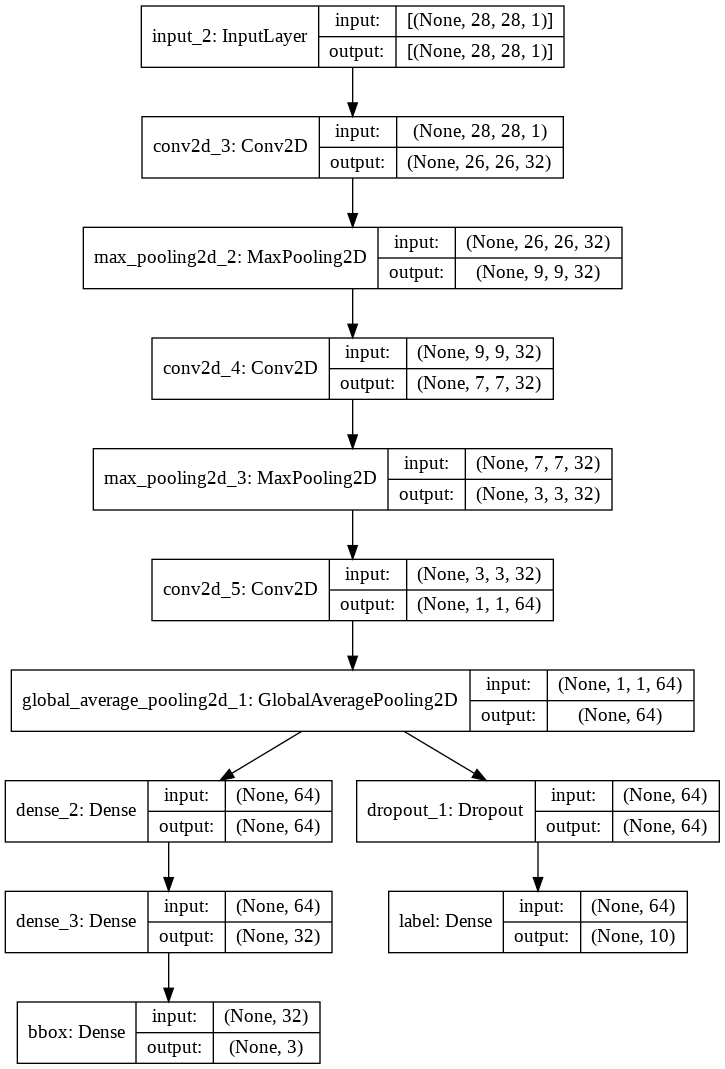

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/CV materials/Assignment-3/Models/q3/model_plot_q3.png', show_shapes=True, show_layer_names=True)

In [ ]:
pred_2[1].shape

(10000, 3)

In [ ]:
def post_process_q2(prediction):
  new_prediction=[]
  labels=prediction[0]
  circle_param=prediction[1]
  for i in range(labels.shape[0]):
    cur_label=labels[i]
    cur_circle=circle_param[i]
    new_labels=np.zeros(10)
    new_circle=np.zeros(3)
    max_value = max(cur_label)
    cur_label=cur_label.tolist()
    max_index = cur_label.index(max_value)
    new_labels[max_index]=1
    new_circle[0]=cur_circle[0]
    new_circle[1]=cur_circle[1]
    new_circle[2]=cur_circle[2]
    #new_labels=np.asarray(new_labels)
    #new_circle=np.asarray(new_circle)
    new_prediction.append([max_index,new_circle])
  
  
  return new_prediction




In [ ]:
post_pred=post_process_q2(pred_2)

In [ ]:
post_pred=np.asarray(post_pred)
post_pred[0][0]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


7

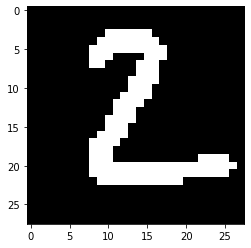

In [ ]:
plt.imshow(new_testing[1],cmap='gray')

In [ ]:
def jaccard_temp_q3(image,prediction,original_label):
  label=prediction[0]
  circle_params=prediction[1]
  score=-1
  if label==original_label:
    mask = np.zeros(image.shape)
    xc=int(circle_params[0])
    yc=int(circle_params[1])
    radiuss=int(circle_params[2])
    if radiuss<0:
      radiuss=0
    mask = cv2.circle(mask, (xc,yc), radiuss, (255,255,255), -1)
    score=jaccard(image,mask)
  else:
    score=0
  return score

In [ ]:
def jaccard_q3(x_data,y_data,prediction):
  avg_jac=0.0
  for i in range(len(x_data)):
    cur_data=x_data[i]
    #cur_data=cur_data.reshape(28,28)
    cur_data=np.asarray(cur_data)
    cur_jac=jaccard_temp_q3(cur_data,prediction[i],y_data[i])
    avg_jac=avg_jac+cur_jac
  avg_jac=avg_jac/len(y_data)
  return avg_jac

In [ ]:
jaccard_q3(new_testing,y_test,post_pred)

0.866982548404099

In [ ]:
from sklearn.metrics import jaccard_score

def jaccard_overlap(orig,predicted,orig_labels):
  avg_jac=0.0
  for i in range(len(orig)):
    cur_label=orig_labels[i]
    if cur_label==predicted[i][0]:
      orig_label=orig[i]
      predicted_label=predicted[i][1]

      orig_image=np.zeros((28,28))
      orig_xc=int(orig_label[0])
      orig_yc=int(orig_label[1])
      orig_radius=int(orig_label[2])
      if orig_radius<0:
        orig_radius=0
      orig_mask = cv2.circle(orig_image, (orig_xc,orig_yc), orig_radius, (255,255,255), -1)

      pred_image=np.zeros((28,28))
      pred_xc=int(predicted_label[0])
      pred_yc=int(predicted_label[1])
      pred_radius=int(predicted_label[2])
      if pred_radius<0:
        pred_radius=0
      pred_mask = cv2.circle(pred_image, (pred_xc,pred_yc), pred_radius, (255,255,255), -1)

      cur_jac=jaccard(orig_mask,pred_mask)

      avg_jac=avg_jac+cur_jac

  avg_jac=avg_jac/len(orig)
  return avg_jac

In [ ]:
jaccard_overlap(oneb_test,post_pred,y_test)

0.8925960726097208

# 1c and 4

In [ ]:
#Training set: x_train,new_trainin_copy
#Validation set: x_cv, y_cv
#Testing set: x_test_2, y_test_2
#Original set: x_train_orig,y_train_orig, x_test_orig, y_test_orig

In [ ]:
def label_generator(image,label):
  rows=image.shape[0]
  cols=image.shape[1]
  final_label=np.zeros((rows,cols,11))
  #otsu_thr,new_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  for i in range(rows):
    for j in range(cols):
      if image[i][j]==0:
        final_label[i][j][0]=1
      else:
        final_label[i][j][label+1]=1

  return final_label

In [ ]:
def concat_images(img1,img2,img3,img4):
  #labels would be [img1,img2,img3,img4]
  #Final image would be of the form [img1 img2
  #                                 img3 img4]

  im1=cv2.hconcat([img1,img2])
  im2=cv2.hconcat([img3,img4])
  final_image=cv2.vconcat([im1,im2])
  return final_image

def generate_images(x_train,y_train):
  new_x=[]
  new_y=[]
  i=0
  while i<len(x_train)-4:
    img1=x_train[i]
    img2=x_train[i+1]
    img3=x_train[i+2]
    img4=x_train[i+3]

    cur_label1=label_generator(img1,y_train[i])
    cur_label2=label_generator(img2,y_train[i+1])
    cur_label3=label_generator(img3,y_train[i+2])
    cur_label4=label_generator(img4,y_train[i+3])

    cur_image=concat_images(img1,img2,img3,img4)
    #cur_image_2=concat_images(img1,img3,img2,img4)
    label1=concat_images(cur_label1,cur_label2,cur_label3,cur_label4)
    #label2=concat_images(cur_label1,cur_label3,cur_label2,cur_label4)

    new_x.append(cur_image)
    #new_x.append(cur_image_2)

    new_y.append(label1)
    #new_y.append(label2)

    i=i+4

  new_x=np.asarray(new_x)
  new_y=np.asarray(new_y)

  return new_x,new_y

In [ ]:
onec_x,onec_y=generate_images(new_training,y_train_orig)

In [ ]:
onec_test_x,onec_test_y=generate_images(new_testing,y_test_orig)

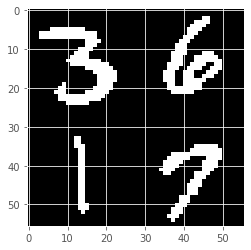

In [ ]:
plt.imshow(onec_x[3],cmap='gray')

In [ ]:
#training data=onec_x,onec_y
#testing data=onec_test_x, onec_test_y
onec_x_copy=onec_x.copy()
onec_x_copy=onec_x_copy.reshape(onec_x.shape[0],onec_x.shape[1],onec_x.shape[2],1)

onec_test_x_copy=onec_test_x.copy()
onec_test_x_copy=onec_test_x_copy.reshape(onec_test_x.shape[0],onec_test_x.shape[1],onec_test_x.shape[2],1)


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
print(tf.__version__)

2.4.1


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=onec_x_copy.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
#-------------------------
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=onec_y.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))
#-------------------------
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(onec_x_copy, onec_y, batch_size=128, epochs=20, callbacks=callbacks,
                    #validation_data=(onec_test_x_copy, onec_test_y)
                    shuffle=True,
                    validation_split=0.2
                    )

Epoch 1/20
94/94 [==============================] - 41s 81ms/step - loss: 0.6695 - binary_accuracy: 0.9233 - val_loss: 0.0566 - val_binary_accuracy: 0.9828

Epoch 00001: val_loss improved from inf to 0.05657, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3.h5
Epoch 2/20
94/94 [==============================] - 6s 62ms/step - loss: 0.0553 - binary_accuracy: 0.9833 - val_loss: 0.0512 - val_binary_accuracy: 0.9845

Epoch 00002: val_loss improved from 0.05657 to 0.05124, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3.h5
Epoch 3/20
94/94 [==============================] - 6s 61ms/step - loss: 0.0515 - binary_accuracy: 0.9844 - val_loss: 0.0490 - val_binary_accuracy: 0.9851

Epoch 00003: val_loss improved from 0.05124 to 0.04904, saving model to /content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3.h5
Epoch 4/20
94/94 [==============================] - 6s 62ms/step - loss: 0.0488 - binary_accuracy: 0.98

In [ ]:
model.save('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3_copy.h5')

In [ ]:
model=load_model('/content/drive/MyDrive/CV materials/Assignment-3/Models/q2/q4modelv3_copy.h5')

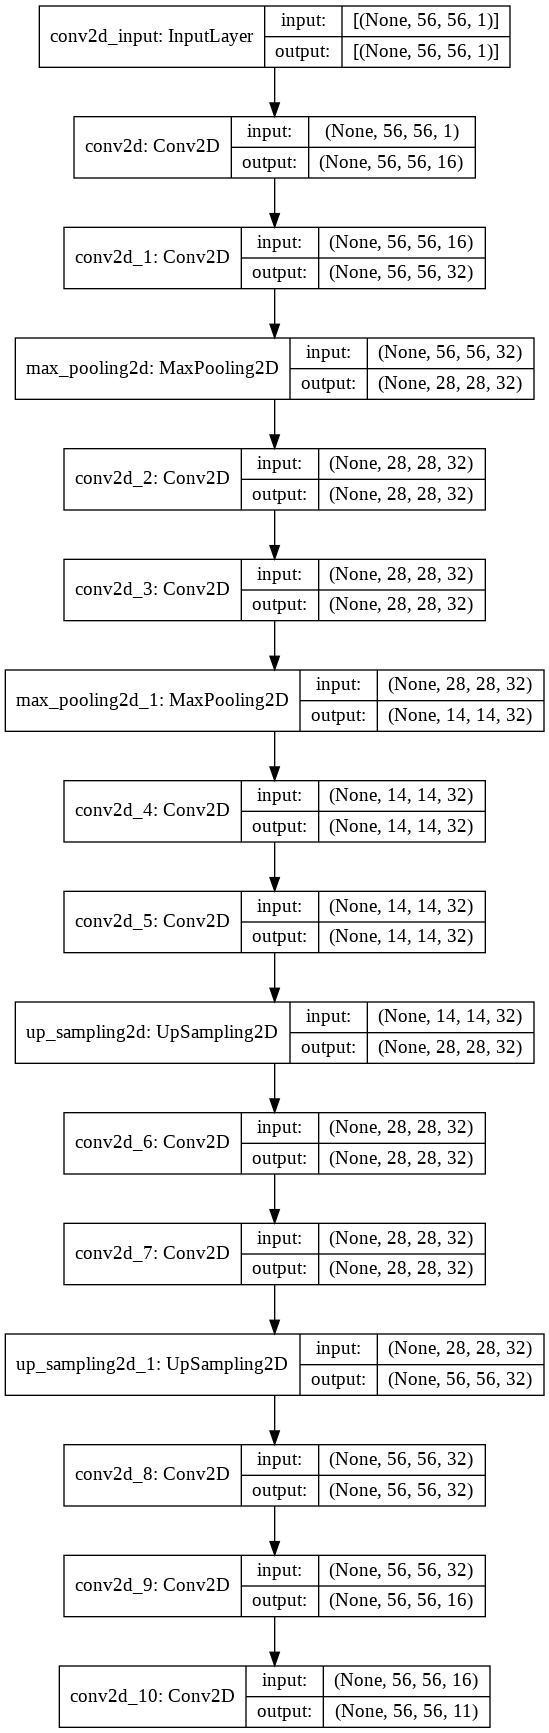

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/CV materials/Assignment-3/Models/q4/model_plot_q4.png', show_shapes=True, show_layer_names=True)

In [ ]:
pred=model.predict(onec_test_x_copy)
#pred_train=model.predict(onec_x_copy)

In [ ]:
rounded_pred=np.round(pred)

In [ ]:
def pred_process(prediction):
  temp=np.zeros(prediction.shape)
  for i in range(len(prediction)):
    cur_pred=prediction[i]
    for j in range(cur_pred.shape[0]):
      for k in range(cur_pred.shape[1]):
        max_value = max(cur_pred[i][j])
        max_index = cur_pred[i][j].index(max_value)
        temp[i][j][max_index]=1

        
  return temp

In [ ]:

def findone(arr):
  index=-1
  for i in range(len(arr)):
    if arr[i]==1.0:
      index=i
  return index

def coloring_labels(img):
  final=np.zeros((img.shape[0],img.shape[1],3))
  colors=[[0,0,0],[255,255,255],[255,0,0],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],[0,255,255],[128,0,0],[0,128,0]]
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      cur_label=img[i][j]
      index=findone(cur_label)
      final[i][j]=colors[index]

  return final


In [ ]:
op=coloring_labels(rounded_pred[3])

In [ ]:
rounded_pred.shape

(2499, 56, 56, 11)

In [ ]:
def jaccard_q4(original,prediction):
  avg_jac=0.0
  for i in range(len(original)):
    cur_label=original[i]
    cur_pred=prediction[i]
    intersection=0
    union=0
    for j in range(cur_label.shape[0]):
      for k in range(cur_label.shape[1]):
        if check_same(cur_label[j][k],cur_pred[j][k]):
          intersection=intersection+1
          union=union+1
        else:
          union=union+1
        
    cur_score=intersection/union
    avg_jac=avg_jac+cur_score
  avg_jac=avg_jac/len(original)
  return avg_jac


In [ ]:
def check_same(arr1,arr2):
  cur_ans=True
  for i in range(len(arr1)):
    if arr1[i]!=arr2[i]:
      cur_ans=False
  return cur_ans
      

In [ ]:
jaccard_q4(onec_test_y,rounded_pred)
#try1-0.9564372943054764

0.9564375495095989

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


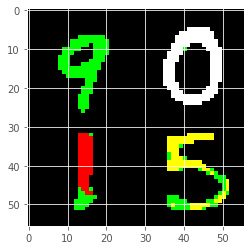

In [ ]:
plt.imshow(op)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


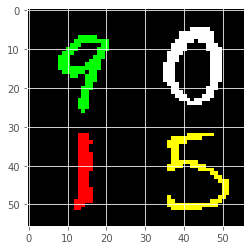

In [ ]:
op1=coloring_labels(onec_test_y[3])
plt.imshow(op1)